In [5]:
# blog_workflow.py
from typing import Dict
from langgraph.graph import StateGraph
from app.models.state import BlogState
from app.services.youtube_service import determine_input, fetch_youtube_subtitles
from app.services.blog_service import (
    parallel_title_content_start,
    generate_blog_title,
    generate_blog_content,
    compose_final_blog,
)
from app.services.publish_service import (
    publish_to_facebook_node,
    publish_to_instagram_node,
)
from app.services.HITL_service import human_approval_node, choose_post_media_node
from langgraph.checkpoint.sqlite import SqliteSaver


def publish_router_node(state: BlogState) -> Dict:
    choice = state.get("postMedia")
    if choice == "fb":
        return {"route": "facebook"}
    elif choice == "instagram":
        return {"route": "instagram"}
    else:
        raise ValueError("Invalid postMedia: must be 'fb' or 'instagram'")


def build_blog_workflow():
    graph = StateGraph(BlogState)

    # --- Nodes ---
    graph.add_node("determine_input", determine_input)
    graph.add_node("fetch_youtube_transcript", fetch_youtube_subtitles)
    graph.add_node("preprocessor", parallel_title_content_start)
    graph.add_node("generate_title", generate_blog_title)
    graph.add_node("generate_content", generate_blog_content)
    graph.add_node("compose_blog", compose_final_blog)
    graph.add_node("human_approval", human_approval_node)
    graph.add_node("choose_post_media", choose_post_media_node)
    graph.add_node("publish_router", publish_router_node)
    graph.add_node("publish_facebook", publish_to_facebook_node)
    graph.add_node("publish_instagram", publish_to_instagram_node)

    # --- Entry ---
    graph.set_entry_point("determine_input")

    # --- Conditional: input type ---
    def route_input(state: Dict) -> str:
        if state.get("inputCategory") == "link":
            return "fetch_youtube_transcript"
        elif state.get("inputCategory") == "topic":
            return "preprocessor"
        else:
            raise ValueError("Unknown inputCategory")

    graph.add_conditional_edges(
        "determine_input",
        route_input,
        {
            "fetch_youtube_transcript": "fetch_youtube_transcript",
            "preprocessor": "preprocessor",
        },
    )

    # --- Normal edges ---
    graph.add_edge("fetch_youtube_transcript", "preprocessor")
    graph.add_edge("preprocessor", "generate_title")
    graph.add_edge("preprocessor", "generate_content")
    graph.add_edge("generate_title", "compose_blog")
    graph.add_edge("generate_content", "compose_blog")

    # --- HITL edges: human approval ---
    graph.add_edge("compose_blog", "human_approval")

    def approval_router(state: Dict) -> str:  # type: ignore
        if state.get("approved") is True:
            return "choose_post_media"
        elif state.get("approved") is None:
            return "human_approval"
        elif state.get("approved") is False:
            return "preprocessor"
        else:
            return "__end__"

    graph.add_conditional_edges(
        "human_approval",
        approval_router,
        {
            "choose_post_media": "choose_post_media",
            "preprocessor": "preprocessor",
            "human_approval": "__end__",
            "__end__": "__end__",
        },
    )

    graph.add_edge("choose_post_media", "publish_router")

    # graph.add_conditional_edges(
    #     "choose_post_media",
    #     lambda state: "publish_router" if state.get("postMedia") else "choose_post_media",
    #     {"publish_router": "publish_router", "choose_post_media": "choose_post_media"},
    # )

    def post_router(state: Dict) -> str:
        if state.get("postMedia") == "fb":
            return "publish_facebook"
        elif state.get("postMedia") == "instagram":
            return "publish_instagram"
        else:
            raise ValueError("Invalid postMedia value")

    graph.add_conditional_edges(
        "publish_router",
        post_router,
        {
            "publish_facebook": "publish_facebook",
            "publish_instagram": "publish_instagram",
        },
    )

    graph.add_edge("publish_facebook", "__end__")
    graph.add_edge("publish_instagram", "__end__")

    return graph


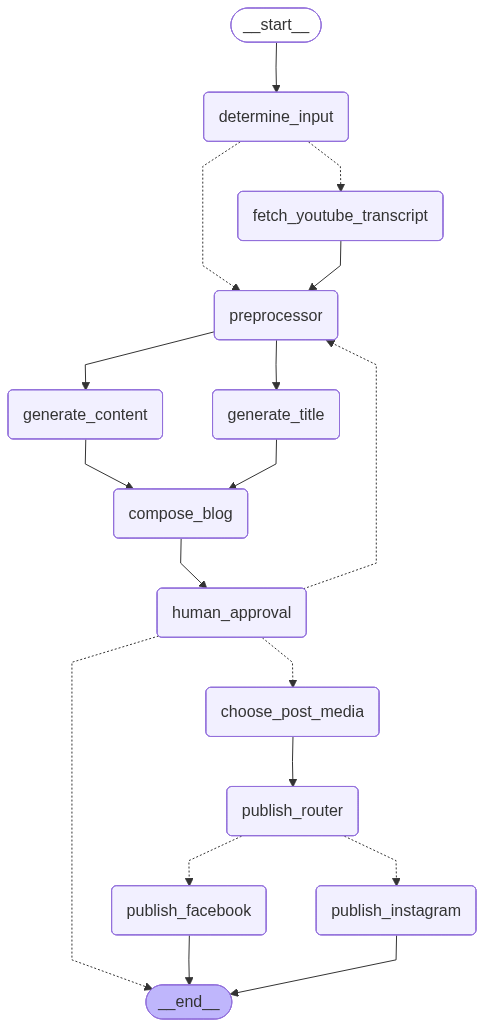

In [6]:
build_blog_workflow().compile()